In [84]:
import cv2
import numpy as np
import imutils
from utils.cttutils import displayImage
from scipy.spatial import distance as dist
from imutils import perspective
from imutils import contours

## Let's start by simplifying the image

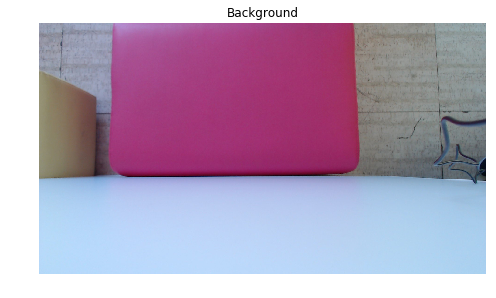

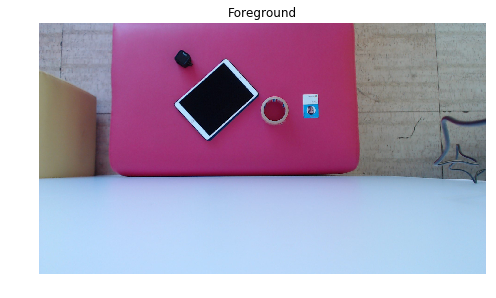

In [85]:
bg = cv2.imread("images/ctt1_bg.jpg")
fg = cv2.imread("images/ctt1_fg.jpg")
displayImage(bg,title='Background')
displayImage(fg,title='Foreground')

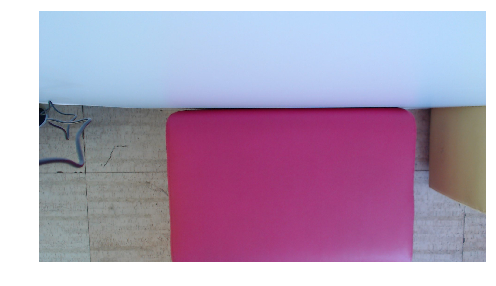

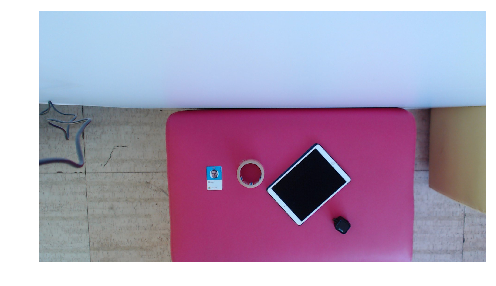

In [86]:
#rotate images
fg = imutils.rotate(fg,180)
bg = imutils.rotate(bg, 180)

displayImage(bg)
displayImage(fg)

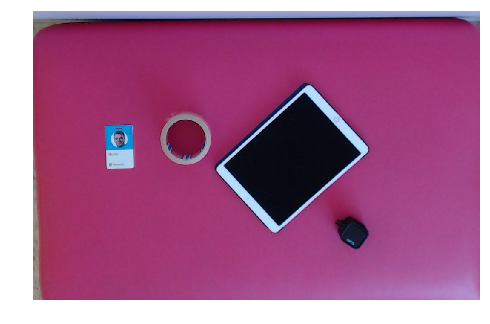

In [87]:
width = 1050
height = 1080
startX = 550
startY = 400

def crop(image):
    return image[startY:startY+height, startX:startX+width]

fg = crop(fg)
bg = crop(bg)

displayImage(fg)

## Let's remove all background information

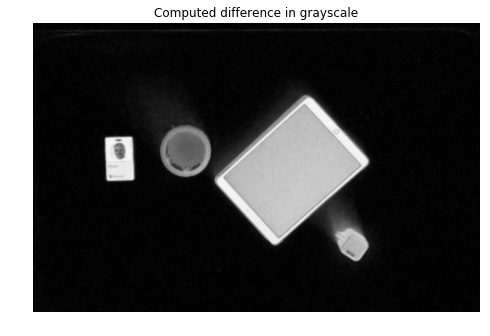

In [88]:
diff = cv2.absdiff(bg, fg)
mask = cv2.cvtColor(diff, cv2.COLOR_BGR2GRAY)

displayImage(mask,title='Computed difference in grayscale')

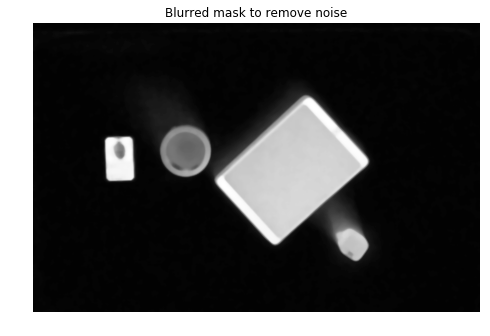

In [89]:
# remove 'salt and pepper' noise: medianBlur should work better for this
mask = cv2.medianBlur(mask, 13)
displayImage(mask, title='Blurred mask to remove noise')

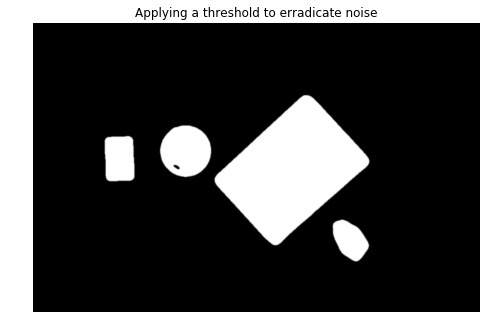

In [90]:
th = 30
imask =  mask>th
displayImage(imask, title='Applying a threshold to erradicate noise')

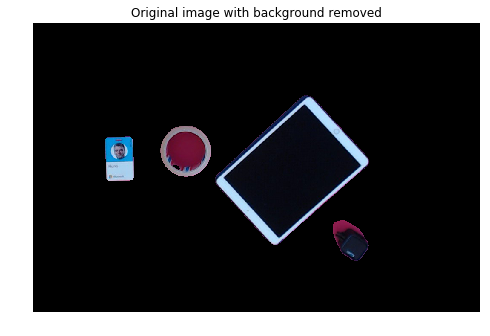

In [91]:
canvas = np.zeros_like(fg, np.uint8)
#canvas[:] = 255
canvas[imask] = fg[imask]
displayImage(canvas, title='Original image with background removed')

## Edge Detection

In [92]:
image = canvas

def DoGrayscaleAndBlur(image):
    # grayscale and blur
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)
    return gray

result = DoGrayscaleAndBlur(image)

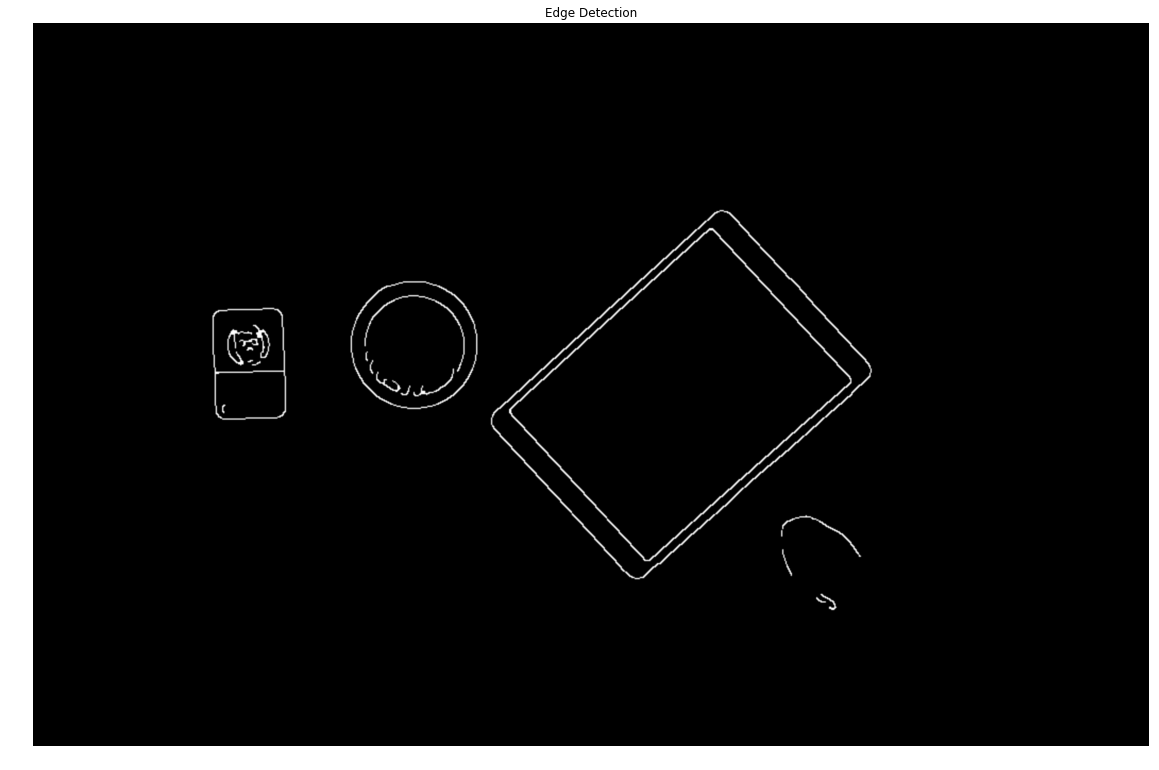

In [93]:
# perform edge detection, then perform a dilation + erosion to
# close gaps in between object edges
edged = cv2.Canny(result, 180, 200)
edged = cv2.dilate(edged, None, iterations=1)
edged = cv2.erode(edged, None, iterations=1)
displayImage(edged, title="Edge Detection", figSize=(20,20))

In [94]:
# find contours in the edge map
cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if imutils.is_cv2() else cnts[1]

# sort the contours from left-to-right and initialize the
# 'pixels per metric' calibration variable
(cnts, _) = contours.sort_contours(cnts, method='left-to-right')
pixelsPerMetric = None

In [95]:
print("All contours:", len(cnts))

# get areas for all contours
areas = []
for c in cnts:
    a = cv2.contourArea(c)
    areas.append(a)
    
areas = np.array(areas)
cnts = np.array(cnts)

# remove small contours
cnts = cnts[np.where(areas >= 600)[0]]
print("Big contours:", len(cnts))

# remove areas of removed contours
areas = areas[np.where(areas >= 600)[0]]

All contours: 8
Big contours: 3


In [96]:
# loop over the contours individually and get bounding boxes
boxes = []
for c in cnts:
    
    # compute the rotated bounding box of the contour
    box = cv2.minAreaRect(c)
    box = cv2.boxPoints(box) 
    box = np.array(box, dtype="int")
 
    # order the points in the contour such that they appear
    # in top-left, top-right, bottom-right, and bottom-left
    # order, then draw the outline of the rotated bounding
    # box
    box = perspective.order_points(box)
    boxes.append(box)

boxes = np.array(boxes)
print("Found {} contours".format(len(boxes)))

Found 3 contours


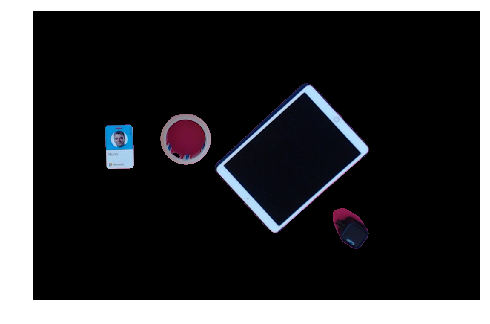

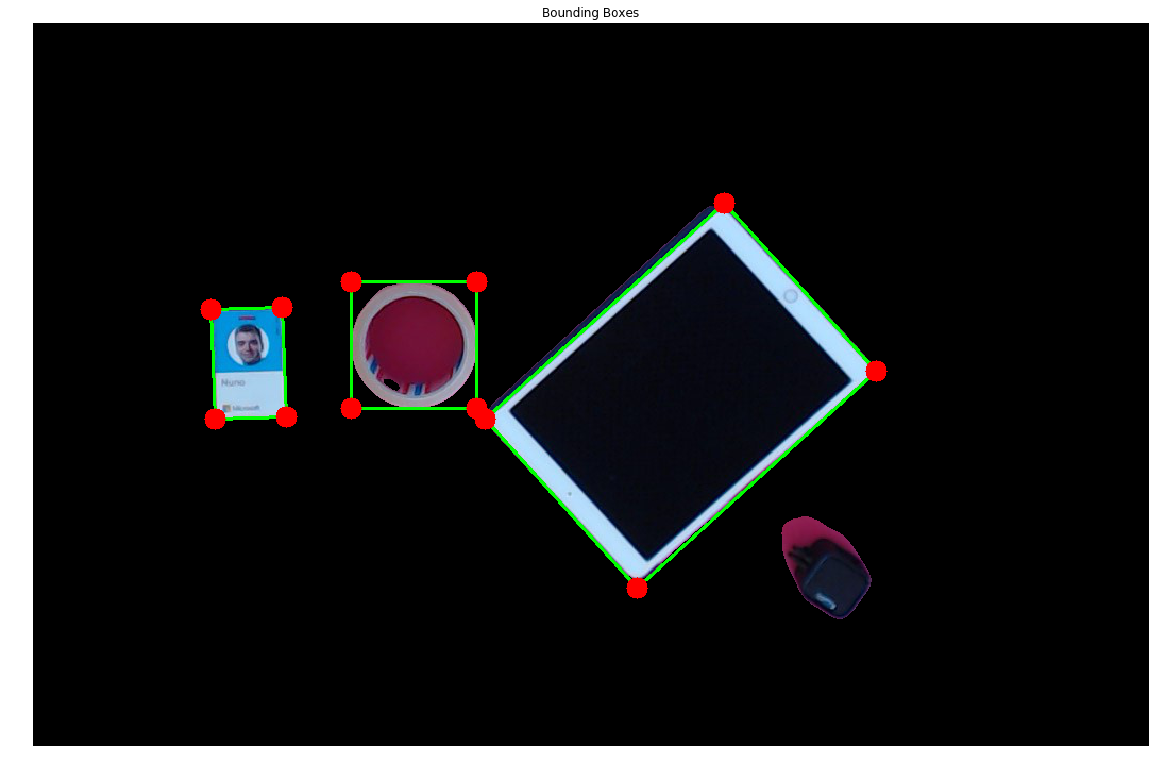

In [97]:
orig = image.copy()

for b in boxes:
    cv2.drawContours(orig, [b.astype("int")], -1, (0, 255, 0), 2)
    for (x, y) in b:
        cv2.circle(orig, (int(x), int(y)), 10, (0, 0, 255), -1)

displayImage(orig, title="Bounding Boxes", figSize=(20,20))

In [98]:
knownWidth = 5.4

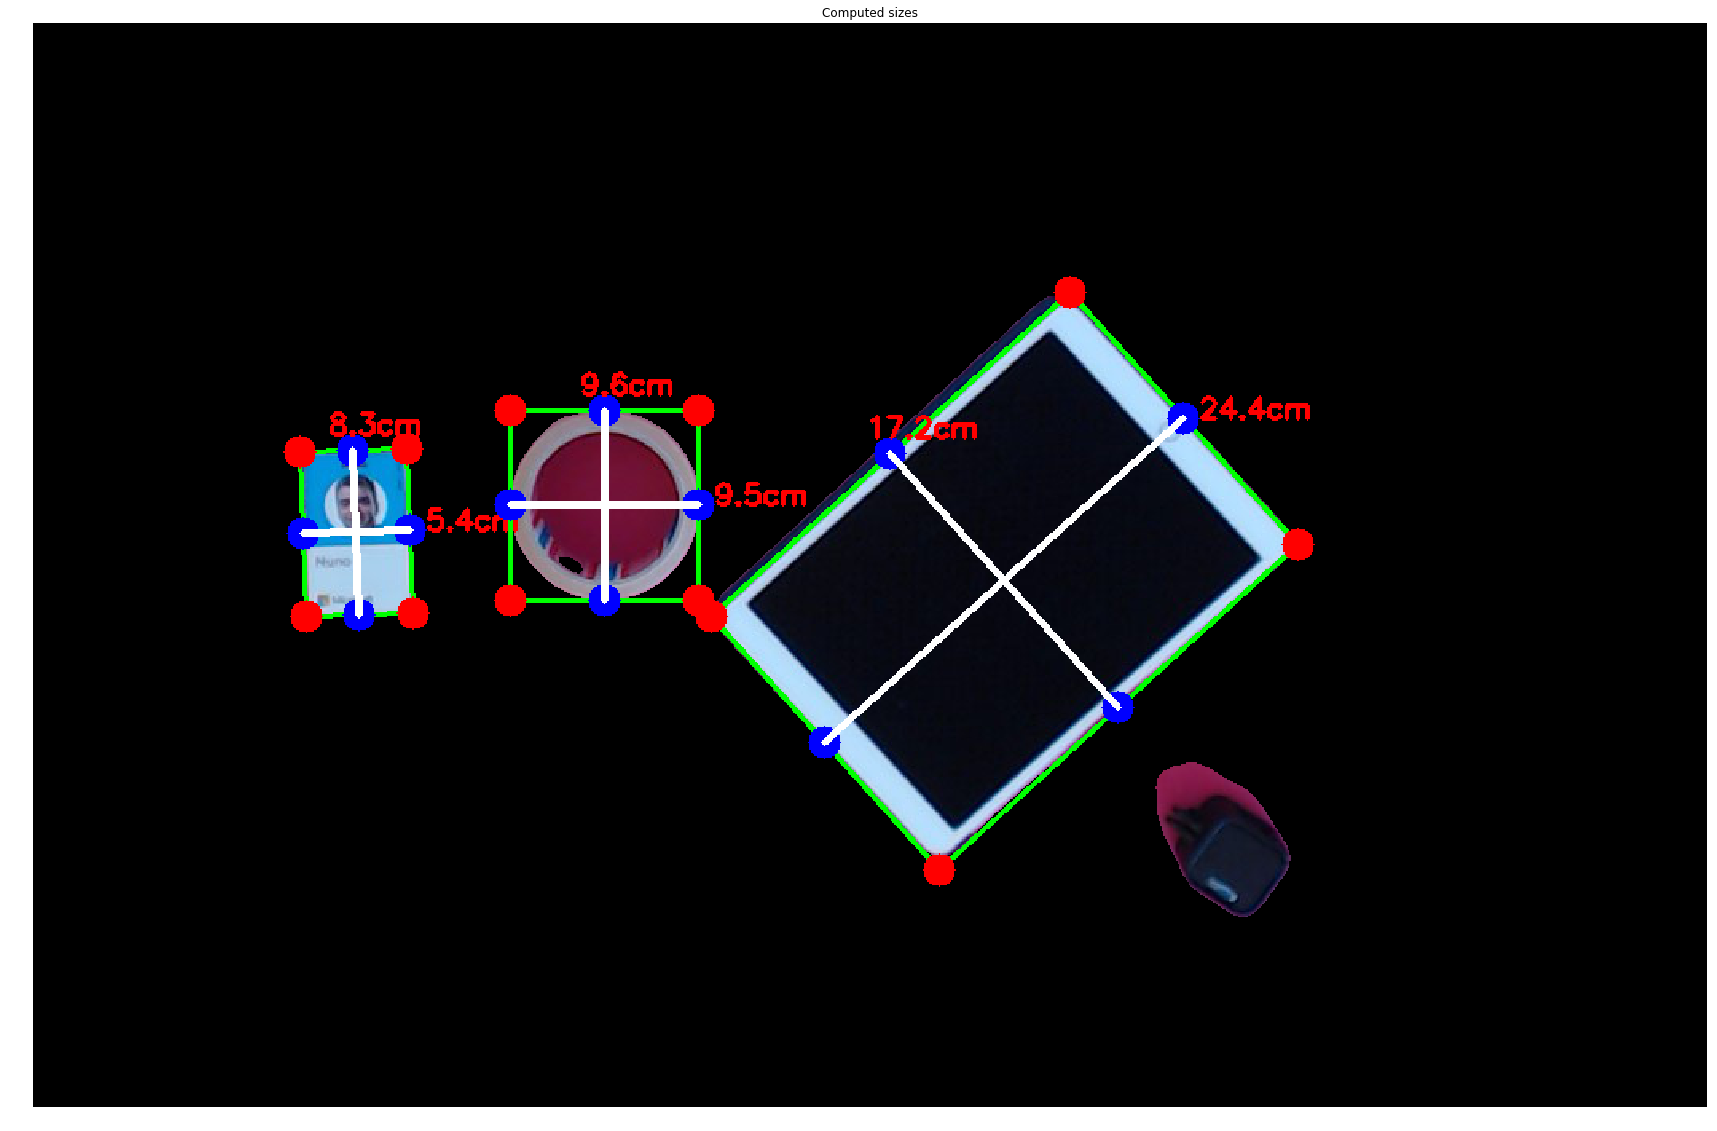

In [99]:
def midpoint(ptA, ptB):
    return ((ptA[0] + ptB[0]) * 0.5, (ptA[1] + ptB[1]) * 0.5)

object_sizes = []

for box in boxes:
    # unpack the ordered bounding box, then compute the midpoint
    # between the top-left and top-right coordinates, followed by
    # the midpoint between bottom-left and bottom-right coordinates
    (tl, tr, br, bl) = box
    (tltrX, tltrY) = midpoint(tl, tr)
    (blbrX, blbrY) = midpoint(bl, br)
 
    # compute the midpoint between the top-left and top-right points,
    # followed by the midpoint between the top-righ and bottom-right
    (tlblX, tlblY) = midpoint(tl, bl)
    (trbrX, trbrY) = midpoint(tr, br)
 
    # draw the midpoints on the image
    cv2.circle(orig, (int(tltrX), int(tltrY)), 10, (255,0, 0), -1)
    cv2.circle(orig, (int(blbrX), int(blbrY)), 10, (255, 0, 0), -1)
    cv2.circle(orig, (int(tlblX), int(tlblY)), 10, (255, 0, 0), -1)
    cv2.circle(orig, (int(trbrX), int(trbrY)), 10, (255, 0, 0), -1)
 
    # draw lines between the midpoints
    cv2.line(orig, (int(tltrX), int(tltrY)), (int(blbrX), int(blbrY)),(255, 255, 255), 4)
    cv2.line(orig, (int(tlblX), int(tlblY)), (int(trbrX), int(trbrY)),(255, 255, 255), 4)
    
    # compute the Euclidean distance between the midpoints
    dA = dist.euclidean((tltrX, tltrY), (blbrX, blbrY))
    dB = dist.euclidean((tlblX, tlblY), (trbrX, trbrY))
 
    # if the pixels per metric has not been initialized, then
    # compute it as the ratio of pixels to supplied metric
    # (in this case, inches)
    if pixelsPerMetric is None:
        pixelsPerMetric = dB / knownWidth
    
    # compute the size of the object
    dimA = dA / pixelsPerMetric
    dimB = dB / pixelsPerMetric
 
    object_sizes.append([box, dimB, dimA])

    # draw the object sizes on the image
    cv2.putText(orig, "{:.1f}cm".format(dimA), (int(tltrX - 15), int(tltrY - 10)), cv2.FONT_HERSHEY_SIMPLEX,0.6, (0, 0, 255), 2)
    cv2.putText(orig, "{:.1f}cm".format(dimB), (int(trbrX + 10), int(trbrY)), cv2.FONT_HERSHEY_SIMPLEX,0.6, (0, 0, 255), 2)
        
displayImage(orig, figSize=(30,30), title='Computed sizes')